In [74]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from google.protobuf.json_format import MessageToDict
from PIL import Image , ImageDraw
import matplotlib.image as mpimg

### Memanggil mediapipe untuk deteksi tangan 

In [75]:
# initisialisasi class tangan
mp_hands = mp.solutions.hands

# mengatur fungsi yang memegang poin landmark
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.3)

# mengatur fungsimelukis ke gambar
mp_drawing = mp.solutions.drawing_utils

### Membaca foto

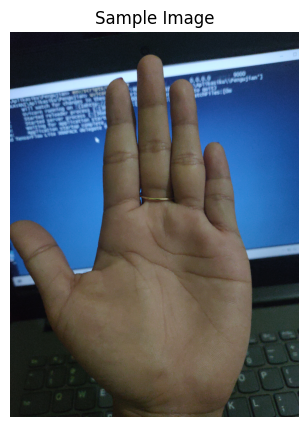

In [76]:
# membaca sample gaambar yang akan dilakukan deteksi
sample_img = cv2.imread('testing/ini (6).jpg')
# sample_img = cv2.flip(sample_img, 1)

# mengatur saiz plt yang nantinya akan menampilkan kembali gambar
plt.figure(figsize = [5, 5])

# menampilkan gambar
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()
sample_img = cv2.flip(sample_img, 1)


### proses jika foto adalah telapak tangan kiri

In [77]:
results = hands.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    
#cek jika foto ada tangan di dalamnya
if not results.multi_hand_landmarks:
    print("Foto harus ada telapak tangan")

#cek jika didalam foto hangan 1 tangan saja
if len(results.multi_handedness) > 1:
    print("Hanya satu telapak tangan yang bisa diramal")

#cek jika foto bukan tangan kiri
tangan =  results.multi_handedness[0].classification[0].label
if(tangan == 'Right'):
    print("Hanya Tangan Kiri Yang Bisa Diramal")

#cek jika foto adalah telapak tangan berdasarkan posisi ibu jari dan kelingking
thumb = None
pinky = None
for hand_no, hand_landmarks in enumerate(results.multi_hand_landmarks):
    thumb = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].x
    pinky = hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].x
cek_tapak_tangan = thumb > pinky
if(cek_tapak_tangan == False):
    print("Sila foto telapak tangan kiri anda")
    
    

### menghilangkan backgroun dan crop telapak tangan

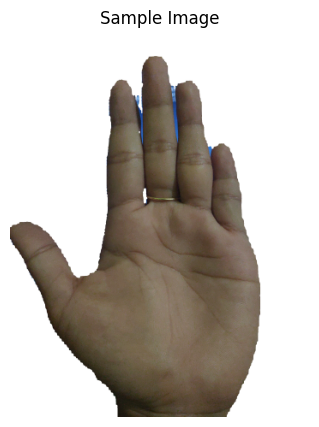

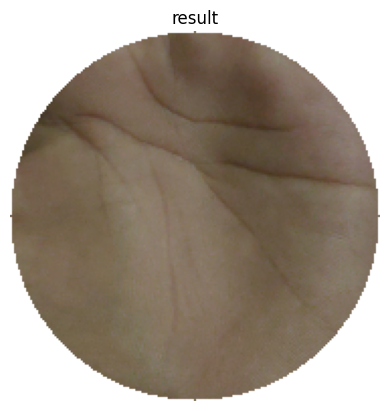

True

In [78]:
#class untuk menghilangkan latar belakang
change_background_mp = mp.solutions.selfie_segmentation
change_bg_segment = change_background_mp.SelfieSegmentation()

def makeCircle(img,circle_y,circle_x,radius):
    image_height, image_width, _ = img.shape
    y = int(circle_y * image_height)
    x = int(circle_x * image_width)
    circle_coordinates = (x,y)
    color = (255, 0, 0)
    thickness = 2
    return cv2.circle(img,circle_coordinates,radius,color,thickness)


image = sample_img
sample_img = sample_img
image = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
image = change_bg_segment.process(image)
image = image.segmentation_mask > 0.9
image = np.dstack((image,image,image))
image = np.where(image, sample_img, 255) 
image = cv2.resize(image, (350,450), interpolation = cv2.INTER_AREA)
shape = image.shape    
results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
image_height, image_width, _ = image.shape


result=None
# print(results.multi_hand_landmarks)
for hand_landmarks in results.multi_hand_landmarks:
    annotated_image = image.copy()
    palm_center_y = (hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].y +
    hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].y)/2.1
    palm_center_x = (hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].x +
    hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].x)/2.1
    myradius = int(image_height/4.9) 
    #annotated_image = makeCircle(annotated_image,palm_center_y,palm_center_x,myradius)
    y = int(palm_center_y * image_height)
    x = int(palm_center_x * image_width)
    circle_coordinates = (x,y)
    mask = np.zeros(image.shape, dtype=np.uint8)
    cv2.circle(mask, circle_coordinates, myradius, (255,255,255), -1)
    ROI = cv2.bitwise_and(image, mask)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    x,y,w,h = cv2.boundingRect(mask)
    result = ROI[y:y+h,x:x+w]
    mask = mask[y:y+h,x:x+w]
    result[mask==0] = (255,255,255)
    
plt.figure(figsize = [5, 5])
plt.title("Sample Image");plt.axis('off');plt.imshow(cv2.flip(annotated_image,1)[:,:,::-1]);plt.show()

plt.title("result");plt.axis('off');plt.imshow(cv2.flip(result,1)[:,:,::-1]);plt.show()
cv2.imwrite("testing/croped1.png", result)



### Mengubah crop image menjadi hitam putih

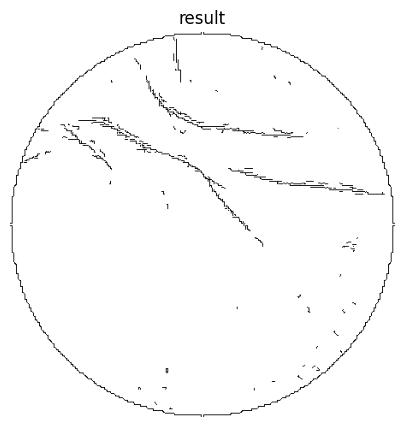

In [79]:
import cv2
image = cv2.imread("testing/croped1.png")
width = 450
height = 450
dim = (width, height)
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
# cv2.imshow("palm",image) #to view the palm in python
cv2.waitKey(0)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,30,45,apertureSize = 3)
# cv2.imshow("edges in palm",edges)
# cv2.waitKey(0)
edges = cv2.bitwise_not(edges)
# cv2.imshow("edges in palm",edges)
cv2.imwrite("testing/croped11.png", edges)
cv2.waitKey(0)
plt.figure(figsize = [5, 5])
plt.title("result");plt.axis('off');plt.imshow(cv2.flip(edges,1)[:,:],cmap='gray');plt.show()

In [80]:
import cv2
import os
import json

TARGET_FILE = 'testing/croped11.png'
IMG_DIR = 'images/'
IMG_SIZE = (450, 450)

# target_img_path = IMG_DIR + TARGET_FILE
target_img = cv2.imread(TARGET_FILE)
target_img = cv2.resize(target_img, IMG_SIZE)
target_hist = cv2.calcHist([target_img], [0], None, [256], [0, 256])

print('TARGET_FILE: %s' % (TARGET_FILE))

bf = cv2.BFMatcher(cv2.NORM_HAMMING)
# detector = cv2.ORB_create()
detector = cv2.AKAZE_create()
(target_kp, target_des) = detector.detectAndCompute(target_img, None)

# print('TARGET_FILE: %s' % (TARGET_FILE))
hasil_ramalan = None

datas = None

with open('dataset.json') as f:
  datas = json.load(f)

pilihan = 2000
image_ramalan = None
files = os.listdir(IMG_DIR)
for file in files:
#     if file == '.DS_Store' or file == TARGET_FILE:
#         continue
    
    comparing_img_path = IMG_DIR + file
    try:
        comparing_img = cv2.imread(comparing_img_path, cv2.IMREAD_GRAYSCALE)
        comparing_img = cv2.resize(comparing_img, IMG_SIZE)
        (comparing_kp, comparing_des) = detector.detectAndCompute(comparing_img, None)
        matches = bf.match(target_des, comparing_des)
        dist = [m.distance for m in matches]
        ret = sum(dist) / len(dist)
    except cv2.error:
        ret = 100000

    print(file, ret)
    if(ret < pilihan):
        pilihan =ret
        image_ramalan = file
        
print(pilihan)
print(image_ramalan)
theindex = None
for index,data in enumerate(datas):
    if(data["id"] == image_ramalan):
        theindex= index
        
hasil_ramalan = datas[theindex]['datanya']
print(hasil_ramalan)

TARGET_FILE: testing/croped11.png
1.png 81.9747191011236
1_2.png 85.32584269662921
1_3.png 87.17696629213484
1_4.png 110.05898876404494
1_5.png 84.3567415730337
2.png 80.28932584269663
2_2.png 99.19101123595506
2_3.png 89.77247191011236
2_4.png 81.99157303370787
2_5.png 80.86235955056179
2_6.png 78.59550561797752
3.png 79.61235955056179
3_2.png 80.12921348314607
3_3.png 84.47191011235955
3_5.png 77.51685393258427
3_6.png 81.25280898876404
4.png 73.33988764044943
4_2.png 72.37359550561797
4_3.png 72.13764044943821
4_4.png 65.97191011235955
4_5.png 70.04775280898876
5.png 68.75
5_2.png 71.55337078651685
5_3.png 71.4438202247191
5_4.png 66.82584269662921
5_5.png 69.23595505617978
6.png 73.23033707865169
6_2.png 73.10393258426966
6_3.png 73.46629213483146
6_4.png 70.96348314606742
6_5.png 72.82584269662921
7.png 68.03932584269663
7_2.png 66.71067415730337
7_3.png 70.10112359550561
7_4.png 66.75561797752809
7_5.png 67.55898876404494
8.png 68.67415730337079
8_2.png 66.54213483146067
8_3.png 

In [81]:
# def makeCircle(img,circle_y,circle_x,radius):
#     image_height, image_width, _ = img.shape
#     y = int(circle_y * image_height)
#     x = int(circle_x * image_width)
#     circle_coordinates = (x,y)
#     color = (255, 0, 0)
#     thickness = 2
#     return cv2.circle(img,circle_coordinates,radius,color,thickness)

# # For static images:
# IMAGE_FILES = [
#    'aran.jpg',
# ]

# change_background_mp = mp.solutions.selfie_segmentation

# change_bg_segment = change_background_mp.SelfieSegmentation()


# with mp_hands.Hands(
#     static_image_mode=True,
#     max_num_hands=2,
#     min_detection_confidence=0.5) as hands:
#   for idx, file in enumerate(IMAGE_FILES):
#     # Read an image, flip it around y-axis for correct handedness output (see
#     # above).
#     image = cv2.flip(cv2.imread(file), 1)
#     sample_img = cv2.flip(cv2.imread(file), 1)
#     width = 350
#     height = 450
#     dim = (width, height)
# #     image = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
# #     image = change_bg_segment.process(image)
# #     plt.figure(figsize=[22,22])
# #     image = image.segmentation_mask > 0.9
# #     image = np.dstack((image,image,image))
# #     image = np.where(image, sample_img, 255)  
# #     image = utils.remove_bground(image)


# #     # resize image's height 600 fixing the ratio
# #     image = utils.ResizeWithAspectRatio(image,height=600)
# #     image = image.resize((200,400))
#     shape = image.shape
# #     image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

#     # Convert the BGR image to RGB before processing.
#     results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# #     print("results:",results)
# #     Print handedness and draw hand landmarks on the image.
# #     print('Handedness:', results.multi_handedness)
#     if not results.multi_hand_landmarks:
#       continue
#     image_height, image_width, _ = image.shape
#     annotated_image = image.copy()
#     circle_coordinates = None
#     for hand_landmarks in results.multi_hand_landmarks:
# #         print('hand_landmarks:', hand_landmarks)
# #         print(
# #           f'Index finger tip coordinates: (',
# #           f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
# #           f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
# #         )
        

#         circle_coordinates1 = [
#         [
# #             (hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP].y + hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].y)/2,
# #             (hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP].x + hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].x)/2
#             int(hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP].x * shape[1]),
#             int(hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP].y * shape[0]),
#         ],
#         [
# #             (hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP].y + hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_PIP].y)/2,
# #             (hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP].x + hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_PIP].x)/2
#             int(hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP].x * shape[1]),
#             int(hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP].y * shape[0]),
#         ],
#         [
# #             (hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_MCP].y + hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP].y)/2,
# #             (hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_MCP].x + hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP].x)/2
#             int(hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].x * shape[1]),
#             int(hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_MCP].y * shape[0]),
#         ],
#         [
# #             (hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].y + hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].y)/2,
# #             (hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].x + hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].x)/2
#             int(hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].x * shape[1]),
#             int(hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].y * shape[0]),
#         ],
#         [
# #             hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].y,
# #             hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].x
#             int((hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].x  - hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].x /2.5) * shape[1]) ,
#             int(hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].y * shape[0]),
#         ],
#         [
# #             hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].y,
# #             hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].x
#             int(hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].x * shape[1]),
#             int(hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].y * shape[0]),
#         ],
#         [
# #             hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_MCP].y,
# #             hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_MCP].x
#             int(hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_MCP].x * shape[1]),
#             int(hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_MCP].y * shape[0]),
#         ],
#         ]
        
#         circle_coordinates = [
#         [
#             hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP].y,
#             hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].x
#         ],
#         [
#             hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP].y,
#             hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP].x
#         ],
#         [
#             hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_MCP].y,
#             hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_MCP].x
#         ],
#         [   
#             hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].y ,
#             hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].x - hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].x/5
#         ],
#         [
#             hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].y,
#             hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].x  - hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].x /2.5
#         ],
#         [
#             hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].y,
#             hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].x
#         ],
#         [
#             hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_MCP].y,
#             hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_MCP].x
#         ],
#         ]

# #         for (circle_y,circle_x) in circle_coordinates:
# #           annotated_image = makeCircle(annotated_image,circle_y,circle_x,10)

#         palm_center_y = (hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].y +
#         hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].y)/2.1
#         palm_center_x = (hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].x +
#         hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].x)/2.1
#         #
#         palm_range = 100
#         myradius = int(image_height/5.2)
#         annotated_image = makeCircle(annotated_image,palm_center_y,palm_center_x,myradius)

#         y = int(palm_center_y * image_height)
#         x = int(palm_center_x * image_width)
#         circle_coordinates = (x,y)
# #         color = (255, 0, 0)
# #         thickness = 2
#         mask = np.zeros(image.shape, dtype=np.uint8)
#         cv2.circle(mask, (x,y), myradius, (255,255,255), -1)
#         ROI = cv2.bitwise_and(image, mask)
#         mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#         x,y,w,h = cv2.boundingRect(mask)
#         result = ROI[y:y+h,x:x+w]
#         mask = mask[y:y+h,x:x+w]
#         result[mask==0] = (255,255,255)
#         cv2.imwrite("croped1.png", result)
# #         cv2.imshow('result', result)

#         mp_drawing.draw_landmarks(
#           annotated_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
#         hand_landmark_x = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width
#         hand_landmark_y = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height

# #     print(circle_coordinates)
    
#     img = cv2.flip(cv2.imread("tanganriska.jpg"),1)
#     sample_img = cv2.flip(cv2.imread("tanganriska.jpg"),1)
#     img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
#     img = change_bg_segment.process(img)
#     plt.figure(figsize=[10,10])
#     img = img.segmentation_mask > 0.9
#     img = np.dstack((img,img,img))
#     img = np.where(img, sample_img, 255)  
#     pts = np.array(circle_coordinates1)

#     ## (1) Crop the bounding rect
#     rect = cv2.boundingRect(pts)
#     x,y,w,h = rect
#     croped = img[y:y+h, x:x+w].copy()

#     ## (2) make mask
#     pts = pts - pts.min(axis=0)

#     mask = np.zeros(croped.shape[:2], np.uint8)
#     cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

#     ## (3) do bit-op
#     dst = cv2.bitwise_and(croped, croped, mask=mask)

#     ## (4) add the white background
#     bg = np.ones_like(croped, np.uint8)*255
#     cv2.bitwise_not(bg,bg, mask=mask)
#     dst2 = bg+ dst


#     cv2.imwrite("croped.png", croped)
#     cv2.imwrite("mask.png", mask)
#     cv2.imwrite("dst.png", dst)
#     cv2.imwrite("dst2.png", dst2)
#     cv2.imwrite(
#         '/tmp/annotated_image' + str(idx) + '.png', cv2.flip(annotated_image, 1))
# #     plt.title("Sample Image");plt.axis('off');plt.imshow("img" + str(idx),cv2.flip(annotated_image,1));plt.show()
# #     cv2.imshow("img" + str(idx),cv2.flip(annotated_image,1))
#     plt.title("Sample Image");plt.axis('off');plt.imshow(cv2.flip(annotated_image,1)[:,:,::-1]);plt.show()
#     cv2.waitKey(0)
